In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.375.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/cats/cat.8762.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/train/dogs/dog.3443.jpg
/kaggle/input/dogs-vs-cats/dogs_vs_cats/train/cats/cat.12461.jpg
/kaggle/input/dogs-vs-cats/test/dogs/dog.375.jpg
/kaggle/input/dogs-vs-cats/test/cats/cat.8762.jpg
/kaggle/input/dogs-vs-cats/train/dogs/dog.3443.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.12461.jpg


### Loading Necessary Packages

In [32]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

import cv2
import imghdr
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

### Checking Data imbalancing

In [4]:
cat_images , dog_images = os.listdir("/kaggle/input/dogs-vs-cats/train/cats") , os.listdir("/kaggle/input/dogs-vs-cats/train/dogs")
print(f"Cat Images are : {len(cat_images)} \nDog images are : {len(dog_images)}")

Cat Images are : 10000 
Dog images are : 10000


In [5]:
def plot_images_from_directory(directory_path, class_animal, num_images=8):
    
    image_filenames = os.listdir(directory_path)

    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    selected_images = random.sample(image_filenames, num_images) # Random selection of images from the directory

    # Plotting the images
    fig, axes = plt.subplots(2, 4, figsize=(8, 8))
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_animal}")
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

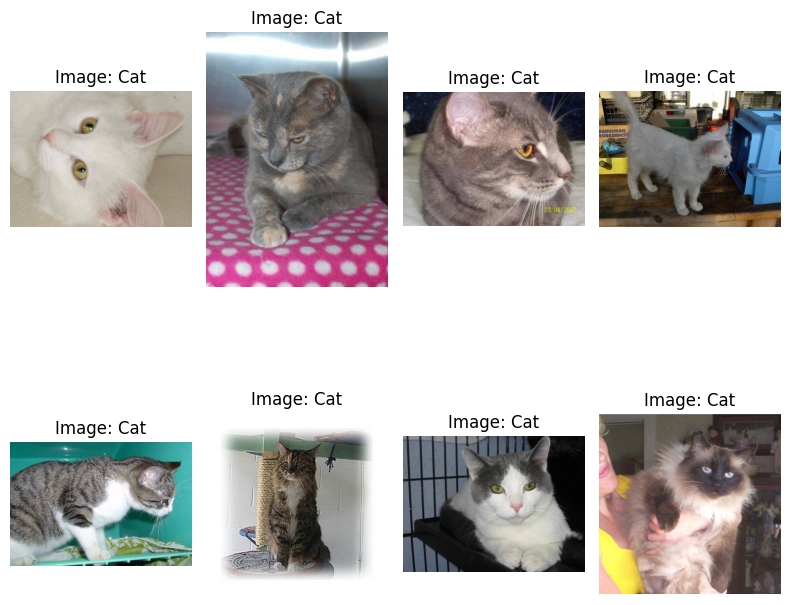

In [6]:
# Image Directory Path
cat_directory_path = '/kaggle/input/dogs-vs-cats/train/cats'
plot_images_from_directory(cat_directory_path, class_animal = 'Cat')

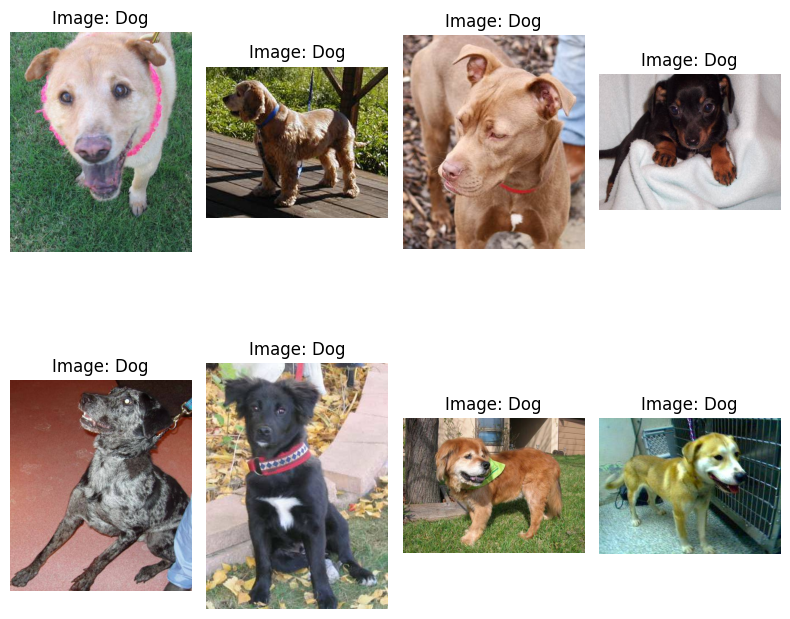

In [7]:
# Image Directory Path
cat_directory_path = '/kaggle/input/dogs-vs-cats/train/dogs'
plot_images_from_directory(cat_directory_path, class_animal = 'Dog')

### Data Cleaning

In [8]:
image_exts = ['jpeg', 'jpg', 'png']

data_dir = '/kaggle/input/dogs-vs-cats'

for root, dirs, files in os.walk(data_dir):

    for file in files:
        file_path = os.path.join(root, file)
        try:
            file_type = imghdr.what(file_path)

            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                img = cv2.imread(file_path)

        except Exception as e:
            print(f'Issue with file {file_path}. Error: {e}')
            os.remove(file_path) 

In [9]:
def image_to_array(image_path):
    try:
        with Image.open(image_path) as img:
            image_array = np.array(img)
            return image_array
    except IOError:
        print(f"Could not read the image file at {image_path}.")
        return None

In [10]:
image_to_array('/kaggle/input/dogs-vs-cats/train/cats/cat.299.jpg')

array([[[118,  97,  80],
        [117,  96,  79],
        [115,  94,  77],
        ...,
        [133, 140, 150],
        [131, 137, 149],
        [128, 134, 146]],

       [[117,  96,  79],
        [116,  95,  78],
        [114,  93,  76],
        ...,
        [132, 139, 149],
        [130, 136, 148],
        [128, 134, 146]],

       [[114,  91,  75],
        [113,  90,  74],
        [111,  90,  73],
        ...,
        [130, 137, 147],
        [129, 135, 147],
        [128, 134, 146]],

       ...,

       [[ 98,  79,  65],
        [ 99,  80,  66],
        [100,  81,  67],
        ...,
        [124, 123, 121],
        [116, 116, 116],
        [124, 125, 127]],

       [[ 99,  80,  66],
        [100,  81,  67],
        [102,  83,  69],
        ...,
        [123, 122, 120],
        [110, 110, 110],
        [118, 119, 121]],

       [[100,  81,  67],
        [102,  83,  69],
        [105,  86,  72],
        ...,
        [123, 122, 120],
        [107, 107, 107],
        [115, 116, 118]]

In [29]:
# Project name
project_name = 'Image_Classification_dogvcats'

# List models
model_names = [
    'Custom_CNN_model']

# Kaggle output working directory
base_dir = '/kaggle/working'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /kaggle/working/Image_Classification_dogvcats


### CNN Model Building

In [11]:
base_dir = '/kaggle/input/dogs-vs-cats/train/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [12]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Resizing images to 150x150
    batch_size=20,
    class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='validation')

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [13]:
train_class_labels = train_generator.class_indices
validation_class_labels = validation_generator.class_indices

print("Training class labels:", train_class_labels)
print("Validation class labels:", validation_class_labels)

Training class labels: {'cats': 0, 'dogs': 1}
Validation class labels: {'cats': 0, 'dogs': 1}


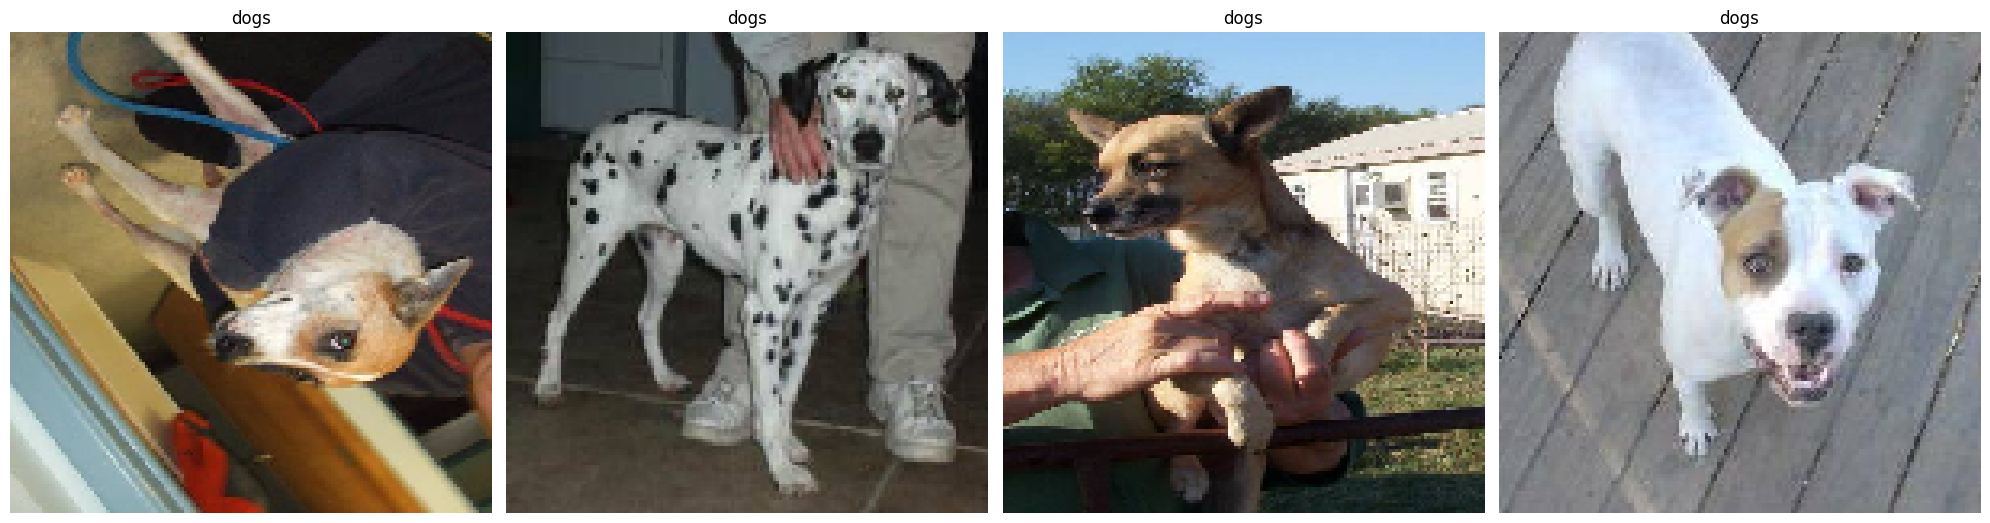

In [14]:
import matplotlib.pyplot as plt

# Function to plot images and their labels
def plot_images_from_generator(generator, num_images=4):
    images, labels = next(generator)

    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        class_labels = dict((v,k) for k,v in generator.class_indices.items())
        ax.set_title(class_labels[int(label)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images_from_generator(train_generator, num_images=4)

In [15]:
train_generator.reset()

### CNN MODEL ARCHITECTURE

In [54]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal',padding='same', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3),kernel_regularizer=tf.keras.regularizers.l2(0.01),padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3),kernel_regularizer=tf.keras.regularizers.l2(0.01),padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3),kernel_regularizer=tf.keras.regularizers.l2(0.01),padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

In [56]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,550,273 (21.17 MB)

 Trainable params: 5,550,273 (21.17 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
train_steps = train_generator.samples // train_generator.batch_size
validation_steps_per_epoch = validation_generator.samples // validation_generator.batch_size
print(train_steps, validation_steps_per_epoch)

800 200


In [57]:
# File path for the model checkpoint
cnn_path = '/kaggle/working/Image_Classification_dogvcats/Custom_CNN_model/saved_models'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)


# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join('/kaggle/working/Image_Classification_dogvcats/Custom_CNN_model/logs','training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [58]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=799,
                    epochs=51,
                    validation_data=validation_generator,
                    validation_steps=199,
                    callbacks=callbacks
)

Epoch 1/51


2024-08-03 08:44:10.417085: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 4.23018, expected 3.647
2024-08-03 08:44:10.417160: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.56591, expected 3.98273
2024-08-03 08:44:10.417170: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.58816, expected 4.00497
2024-08-03 08:44:10.417179: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.66571, expected 4.08252
2024-08-03 08:44:10.417187: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 3.90331, expected 3.32012
2024-08-03 08:44:10.417196: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 33: 4.68341, expected 4.10022
2024-08-03 08:44:10.417205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 56: 4.42163, expected 3.83844
2024-08-03 08:44:10.417214: E external/local_xla/xl

799/799 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5288 - loss: 1.6386
Epoch 1: val_loss improved from inf to 0.73167, saving model to /kaggle/working/Image_Classification_dogvcats/Custom_CNN_model/saved_models/Custom_CNN_model.keras
799/799 ━━━━━━━━━━━━━━━━━━━━ 54s 59ms/step - accuracy: 0.5288 - loss: 1.6379 - val_accuracy: 0.5013 - val_loss: 0.7317 - learning_rate: 0.0010
Epoch 2/51
  1/799 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2500 - loss: 0.7429
Epoch 2: val_loss did not improve from 0.73167
799/799 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.2500 - loss: 0.7429 - val_accuracy: 0.4500 - val_loss: 0.7645 - learning_rate: 0.0010
Epoch 3/51
798/799 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5460 - loss: 0.7753
Epoch 3: val_loss improved from 0.73167 to 0.65118, saving model to /kaggle/working/Image_Classification_dogvcats/Custom_CNN_model/saved_models/Custom_CNN_model.keras
799/799 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.5461 - loss: 0.7752 - val_accur

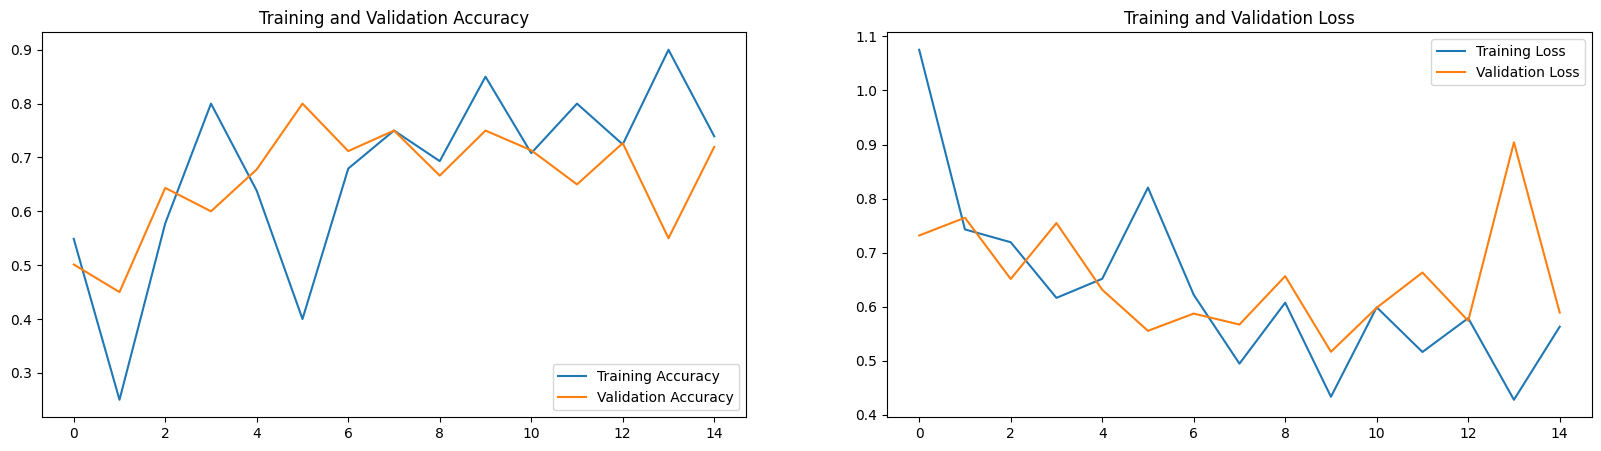

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Evaluation

In [60]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = '/kaggle/input/dogs-vs-cats/test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [46]:
probabilities = model.predict(test_generator,
                              steps=int(np.ceil(test_generator.samples/test_generator.batch_size)))
probabilities

250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step


array([[0.49477807],
       [0.44616458],
       [0.44008675],
       ...,
       [0.49512127],
       [0.4968194 ],
       [0.3443723 ]], dtype=float32)

In [61]:
test_generator.reset()

true_classes = test_generator.classes

probabilities = model.predict(test_generator,
                              steps=int(np.ceil(test_generator.samples/test_generator.batch_size)))

predicted_classes = (probabilities > 0.5).astype(int).squeeze()


class_labels = list(test_generator.class_indices.keys())
predicted_classes

250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step


array([0, 0, 0, ..., 0, 1, 0])

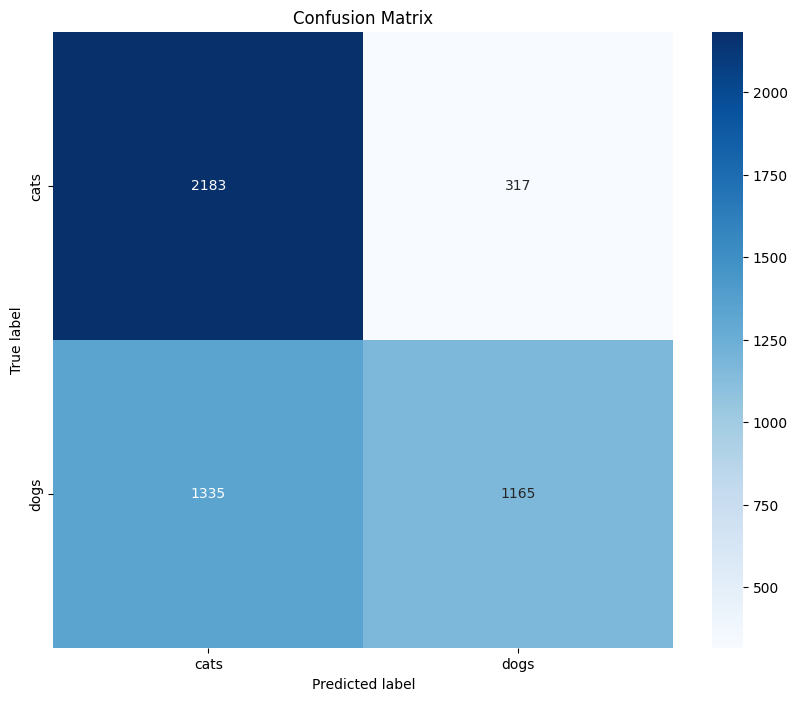

In [62]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [63]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Test loss: {loss:.2f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.8078 - loss: 0.4808
Test accuracy: 66.96%
Test loss: 0.65


In [65]:
def make_prediction(image_path):
    img = load_img(img_path, target_size=(150, 150))  # Resizing the image
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    prediction = model.predict(img_array)
    print("Prediction:", prediction)

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    if prediction[0][0] > 0.5:
        plt.title('Predicted: Dog')
    else:
        plt.title('Predicted: Cat')
    plt.imshow(img)  # Show the same image as prediction
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: [[0.12958543]]


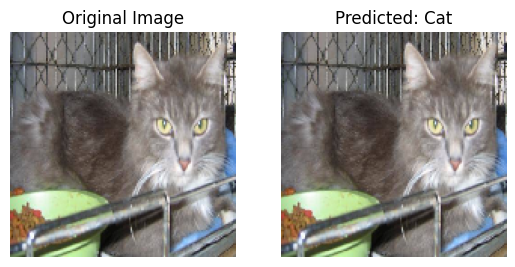

In [67]:
# Load and preprocess the image
img_path = '/kaggle/input/dogs-vs-cats/test/cats/cat.10169.jpg'
make_prediction(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: [[0.7311577]]


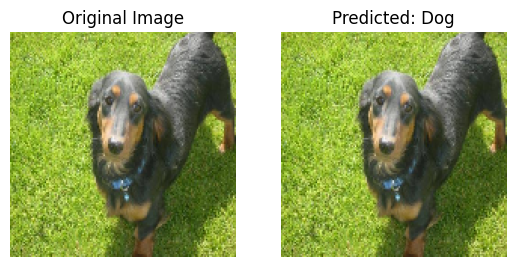

In [70]:
img_path = '/kaggle/input/dogs-vs-cats/test/dogs/dog.10032.jpg'
make_prediction(img_path)

### Checking Wrong Predictions

In [71]:
# Reset the test_generator before making predictions
test_generator.reset()

# Predict the whole test set
predictions = model.predict(test_generator, verbose=1)

# The predictions will be in the format of probabilities. You'll need to convert these to binary labels (0 or 1) based on a 0.5 threshold.
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
true_classes = test_generator.classes
misclassified_indices = np.where(predicted_classes != true_classes)[0]
misclassified_count = len(misclassified_indices)
print(f"Total misclassifications in the test set: {misclassified_count} out of {len(true_classes)}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step
Total misclassifications in the test set: 1652 out of 5000


250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step
Total misclassifications: 1652


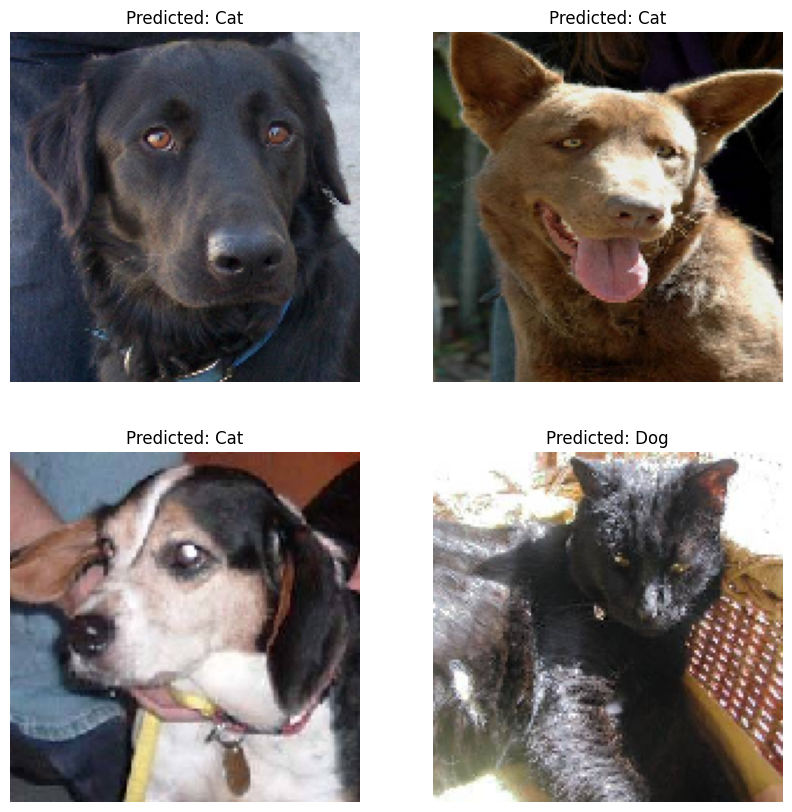

In [73]:
# Generate predictions for all test images
predictions = model.predict(test_generator)
# Convert predictions to binary (0 or 1) based on a 0.5 threshold
predicted_classes = predictions > 0.5

# Retrieve the true labels from the generator
true_classes = test_generator.classes

# Filenames can also be useful for debugging
filenames = test_generator.filenames
# Identifying indices of misclassified images
misclassified_indices = np.where(predicted_classes.flatten() != true_classes)[0]

print(f"Total misclassifications: {len(misclassified_indices)}")


# Select a random subset of misclassified images
num_samples_to_display = 4
random_indices = random.sample(list(misclassified_indices), num_samples_to_display)

# Plot
plt.figure(figsize=(10, 10))
for i, index in enumerate(random_indices, 1):
    # Load image
    img_path = test_dir + '/' + filenames[index]
    img = load_img(img_path, target_size=(150, 150))

    # Predicted class
    predicted_class = "Dog" if predicted_classes[index] else "Cat"

    # Display
    plt.subplot(2, 2, i)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
plt.show()